In [2]:
# Set parameters
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import TheilSenRegressor

u = 3.4e-05
s = 0.4/100
T = 3
years=25
days = int(np.floor(years/4.))*366+(years-int(np.floor(years/4.)))*365
t_tot = int(days/T)
d = lambda j: (1-s)**(j+1)/2
b = lambda j: 1-d(j)
p = [[b(0)*(1-u), d(0), b(0)*u], [b(1), d(1), 0]]

In [3]:
# Run simulation, using np.random.multinomial to find the number of birth,␣death and mutation cells
def simulation(p0, N0, seed=None):
    if seed==None: seed = np.random.randint(0, 987654321)
    np.random.seed(seed)
    
    N = [[int(N0*p0), N0-int(N0*p0)]]
    for t in range(t_tot):
        M_j_prev = 0; N_new = [0, 0]
        for j in range(2):
            try:
                B_j, D_j, M_j = np.random.multinomial(N[t][j], p[j])
            except ValueError:
                N_1, N_2 = np.array(N).T
                return N_1, N_2, True, seed
            N_new[j] = N[t][j] + B_j - D_j + M_j_prev
            M_j_prev = M_j
        N.append(N_new)
    N_1, N_2 = np.array(N).T
    return N_1, N_2, False, seed

In [4]:
# Find seeds in which the population 2 survive
def find_survive(num_trials, p0, N0):
    seeds = []
    while True:
        N_1, N_2, flag, seed = simulation(p0, N0)

        if not flag and N_2[-1]!= 0:
            seeds.append(seed)
        if len(seeds) == num_trials: break
    print('seeds: ', ' '.join([str(seed) for seed in seeds]))
    return seeds

In [8]:
# Get the seeds
num_trials = 10
p0_grid = np.arange(0.1,1,0.1)

dic_seed = {}
for p0 in p0_grid:
    seed = find_survive(num_trials, p0, 10)
    dic_seed[p0] = seed

C:\Users\belle\AppData\Local\Temp/ipykernel_6932/1337237587.py:15: RuntimeWarning: overflow encountered in long_scalars
  N_new[j] = N[t][j] + B_j - D_j + M_j_prev


seeds:  473726723 595028107 674193277 27456996 152984203 17572512 545213489 946212593 968857656 345341846
seeds:  396227744 616099887 678873354 53597313 98472826 500671012 211842066 76527463 890197643 692894556
seeds:  235849499 371659549 697400679 786424583 552823000 121009217 465424948 751314043 48734859 271112583
seeds:  116889543 297349638 528214477 976741531 458196807 337400502 481895430 402354247 404758213 911375367
seeds:  922817875 314294828 517553958 947130180 113452141 636950317 203151797 434798443 245117605 566546334
seeds:  104588629 543095836 555533359 727466243 187605644 49928783 97390115 262777897 333152700 531798452
seeds:  833724607 749525247 834448777 645142433 906644145 738062388 674433800 797721248 571780507 508688666
seeds:  249070510 278237575 618858381 644654558 731792669 78255828 522660462 934600737 908558585 415671456
seeds:  407463671 233872515 74477148 909152410 271417879 375552312 502686025 113693796 896672802 102138893


In [9]:
# Store simulations
if not os.path.exists: os.mkdir('sim')

for p0 in p0_grid:
    for trial in range(10):
        N_1, N_2, flag, seed = simulation(p0, 10, seed=dic_seed[p0][trial])
        np.save('./sim/p0={:.2f}_seed={}.npy'.format(p0, dic_seed[p0][trial]), [N_1, N_2])

C:\Users\belle\AppData\Local\Temp/ipykernel_6932/1337237587.py:15: RuntimeWarning: overflow encountered in long_scalars
  N_new[j] = N[t][j] + B_j - D_j + M_j_prev


In [10]:
# Fit slope & Visualize simulation


def log_filter(x):
    return [np.log(i) if i>0 else 0 for i in x]

def get_files(p0):
    res = []
    for file in os.listdir('./sim/'):
        if 'p0={:.2f}'.format(p0) in file: res.append(file)
    return res

def fit_fitness(p0):
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    idx = -1; start = 2000
    a1s, a2s = [], []
    files = get_files(p0); N = len(files)
    print('Number of files: {}'.format(N))
    color_red = sns.color_palette("YlOrBr", N)
    color_blue = sns.color_palette("Blues", N)
    
    for trial in range(len(files)):
        N_1, N_2 = np.load(os.path.join('./sim/', files[trial]))
        estimator1 = TheilSenRegressor()
        estimator1.fit(np.array(range(start, len(N_1))).reshape(-1,1), log_filter(N_1)[start:])
        a1, b1 = estimator1.coef_.item(), estimator1.intercept_
        label1 = '$N_1$, simulation' if trial==9 else ''
        label2 = '$N_1$, fitted' if trial==9 else ''
        ax1.plot(log_filter(N_1), color=color_red[trial], label=label1)
        ax2.plot(a1*np.array(range(len(N_1)))+b1, color=color_red[trial], label=label2)
        a1s.append(a1)

        estimator2 = TheilSenRegressor()
        estimator2.fit(np.array(range(start, len(N_2))).reshape(-1,1), log_filter(N_2)[start:])
        a2, b2 = estimator2.coef_.item(), estimator2.intercept_
        label1 = '$N_2$, simulation' if trial==9 else ''
        label2 = '$N_2$, fitted' if trial==9 else ''
        ax1.plot(log_filter(N_2), color=color_blue[trial], label=label1)
        ax2.plot(a2*np.array(range(len(N_2)))+b2, color=color_blue[trial], label=label2)
        a2s.append(a2)

    ax1.set_ylim((0,20))
    ax2.set_ylim((0,20))
    ax1.set_xlabel('time'); ax1.set_ylabel('log(N)'); ax1.legend()
    ax2.set_xlabel('time'); ax2.set_ylabel('log(N)'); ax2.legend()
    plt.suptitle('$p_0=${:.2f}'.format(p0))
    plt.savefig('./fig/p0={:.2f}.png'.format(p0), dpi=300); plt.clf()
    
    return a1s, a2s

all_a1s, all_a2s = [], []
for p0 in p0_grid:
    a1s, a2s = fit_fitness(p0)
    all_a1s += [[p0, a1] for a1 in a1s]
    all_a2s += [[p0, a2] for a2 in a2s]

Number of files: 30
Number of files: 30
Number of files: 30
Number of files: 30
Number of files: 30
Number of files: 30
Number of files: 30
Number of files: 30
Number of files: 30


<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

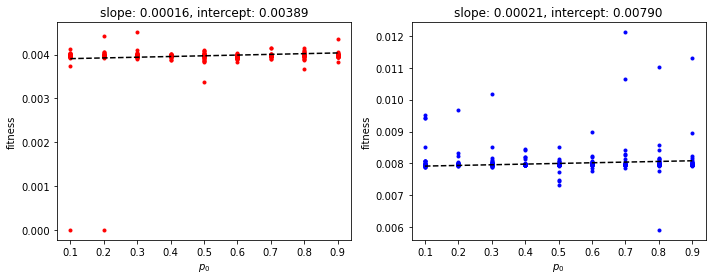

In [12]:
x1, y1 = zip(*all_a1s)
x2, y2 = zip(*all_a2s)

estimator1 = TheilSenRegressor()
estimator1.fit(np.array(x1).reshape(-1,1), y1)
a1, b1 = estimator1.coef_.item(), estimator1.intercept_

estimator2 = TheilSenRegressor()
estimator2.fit(np.array(x2).reshape(-1,1), y2)
a2, b2 = estimator2.coef_.item(), estimator2.intercept_

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(x1, y1, 'r.')
ax2.plot(x2, y2, 'b.')
ax1.plot(p0_grid, a1*p0_grid+b1, 'k--')
ax2.plot(p0_grid, a2*p0_grid+b2, 'k--')
ax1.set_title('slope: {:.5f}, intercept: {:.5f}'.format(a1, b1)); ax1.set_xlabel('$p_0$'); ax1.set_ylabel('fitness')
ax2.set_title('slope: {:.5f}, intercept: {:.5f}'.format(a2, b2)); ax2.set_xlabel('$p_0$'); ax2.set_ylabel('fitness')
plt.tight_layout()
plt.savefig('no_competition.png', dpi=300)